In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential, Input

%load_ext autoreload

# %aimport covid_flu
# cf = covid_flu
import covid_flu as cf

%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Incorporating state information

In this notebook, we take the best models used in `0_rnn_flu.ipynb` and add in state-specific information. We will try the following approaches:

1. Adding an embedding layer that is concatenated with the final hidden state in the FCN block
2. Adding a feature layer (based on state features) that is concatenated with the final hidden state in the FCN block

Then, we will attempt a model that jointly predicts all states at once.

Input: `(batch_size, max_history_len, n_states)`

Output: `(batch_size, target_len, n_states)`

We will attempt an attention mechanism in the FCN block that takes into account state neighbour relations and state commuting relations.

## Preparing Data

In [38]:
# Hyperparams
TEST_SIZE = 0.2
MAX_LEN = 368
MAX_HISTORY_LEN = MAX_LEN - 1
MIN_HISTORY_LEN = 25
TARGET_LEN = 1
PAD_VAL = -1

In [39]:
df_flu = cf.utils.load_flu_data()
df_flu.head()

states = df_flu['state'].unique()
n_states = len(states)

In [40]:
states

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
       'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York City', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [41]:
X_train, X_test = cf.time_series.train_test_split(df_flu['wili'].values,
                                                  df_flu['state'].values,
                                                  test_size=TEST_SIZE)

In [42]:
X_train_var, y_train = cf.time_series.prepare_all_data_walk_forward(X_train,
                                                                    min_len=MIN_HISTORY_LEN,
                                                                    max_len=MAX_LEN,
                                                                    target_len=TARGET_LEN,
                                                                    pad_val=PAD_VAL)
# # The validation set adds a bit of the training set (the last `MIN_HISTORY_LEN`)
# X_test_aug = []
# for x_train, x_test in zip(X_train, X_test):
#     X_test_aug.append(np.concatenate((x_train[-MIN_HISTORY_LEN:], x_test)))
    
X_test_var, y_test = cf.time_series.prepare_all_data_walk_forward(X_test,
                                                                  min_len=MIN_HISTORY_LEN,
                                                                  max_len=MAX_LEN,
                                                                  target_len=TARGET_LEN,
                                                                  pad_val=PAD_VAL)

ds_train, ds_test = cf.time_series.make_datasets(X_train_var,
                                                 X_test_var,
                                                 y_train,
                                                 y_test)


## Simple LSTM model (one state at a time)

Input: `(batch_size, max_history_len, 1)`

Output: `(batch_size, target_len, 1)`

In [47]:
# Defining hyperparams
BATCH_SIZE = 64
EPOCHS = 10
HIDDEN_SIZE = 32
PRE_OUTPUT_DENSE_SIZE = 32

def make_masked_lstm(max_len,
                     target_len=1,
                     hidden_size=16,
                     mask_value=-1,
                     pre_output_dense_size=None,
                     dropout_rate=0.):
    model = tf.keras.models.Sequential()
    model.add(layers.Masking(mask_value=mask_value, input_shape=(max_len, 1)))
    model.add(layers.LSTM(hidden_size))
    if pre_output_dense_size:
        model.add(layers.Dense(pre_output_dense_size, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(target_len))
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [48]:
lstm1 = make_masked_lstm(MAX_LEN,
                         TARGET_LEN,
                         HIDDEN_SIZE,
                         mask_value=PAD_VAL,
                         pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE)
lstm1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 368, 1)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


In [49]:
history1 = lstm1.fit(ds_train,
                     validation_data=ds_test,
                     epochs=EPOCHS)

Train for 71 steps, validate for 14 steps
Epoch 1/10
71/71 [==============================] - 62s 879ms/step - loss: 2.3702 - val_loss: 1.0784
Epoch 2/10
71/71 [==============================] - 41s 575ms/step - loss: 0.7002 - val_loss: 0.4444
Epoch 3/10
71/71 [==============================] - 41s 576ms/step - loss: 0.4799 - val_loss: 0.3723
Epoch 4/10
71/71 [==============================] - 53s 742ms/step - loss: 0.4471 - val_loss: 0.3546
Epoch 5/10
71/71 [==============================] - 46s 651ms/step - loss: 0.4355 - val_loss: 0.3543
Epoch 6/10
71/71 [==============================] - 48s 671ms/step - loss: 0.4347 - val_loss: 0.3399
Epoch 7/10
71/71 [==============================] - 49s 689ms/step - loss: 0.4305 - val_loss: 0.3520
Epoch 8/10
71/71 [==============================] - 57s 802ms/step - loss: 0.4268 - val_loss: 0.3486
Epoch 9/10
71/71 [==============================] - 61s 862ms/step - loss: 0.4207 - val_loss: 0.3430
Epoch 10/10
71/71 [==============================

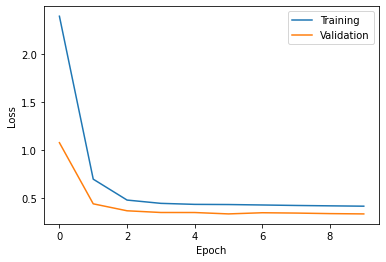

In [50]:
cf.plotting.plot_history(history1)

## Adding state information

In [51]:
# Encoding state
id2state = {i: state for i, state in enumerate(states)}
state2id = {state: i for i, state in enumerate(states)}
state_ids = [state2id[state] for state in states]

In [52]:
data_train = cf.time_series.prepare_all_data_walk_forward(X_train,
                                                          min_len=MIN_HISTORY_LEN,
                                                          max_len=MAX_LEN,
                                                          target_len=TARGET_LEN,
                                                          pad_val=PAD_VAL,
                                                          extra_info=state_ids)

data_test = cf.time_series.prepare_all_data_walk_forward(X_test_aug,
                                                         min_len=MIN_HISTORY_LEN,
                                                         max_len=MAX_LEN,
                                                         target_len=TARGET_LEN,
                                                         pad_val=PAD_VAL,
                                                         extra_info=state_ids)

ds_train_state = cf.time_series.make_dataset(data_train)
ds_test_state = cf.time_series.make_dataset(data_test)

In [53]:
STATE_EMBED_SIZE = 16

def make_masked_state_lstm(max_len,
                           state_embed_size,
                           target_len=1,
                           hidden_size=16,
                           mask_value=-1,
                           pre_output_dense_size=32):
    
    ts_input = Input(shape=(max_len, 1))
    state_input = Input(shape=(1,))
    
    x = layers.Masking(mask_value=mask_value)(ts_input)
    x = layers.LSTM(hidden_size)(x)    
    y = layers.Embedding(n_states, state_embed_size)(state_input)
    y = layers.Flatten()(y)
    x = layers.Concatenate()([x, y])
    x = layers.Dense(pre_output_dense_size, activation='relu')(x)
    x = layers.Dense(1, activation='linear')(x)
    
    model = Model(inputs=[ts_input, state_input], outputs=x)
    model.compile(optimizer='adam', loss='mse')
    return model

In [54]:
lstm_state = make_masked_state_lstm(MAX_LEN,
                                    STATE_EMBED_SIZE,
                                    target_len=TARGET_LEN,
                                    hidden_size=HIDDEN_SIZE,
                                    mask_value=PAD_VAL,
                                    pre_output_dense_size=PRE_OUTPUT_DENSE_SIZE)
lstm_state.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 368, 1)]     0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
masking_9 (Masking)             (None, 368, 1)       0           input_18[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 16)        848         input_19[0][0]                   
____________________________________________________________________________________________

In [55]:
history_state = lstm_state.fit(ds_train_state,
                               validation_data=ds_test_state,
                               epochs=EPOCHS)

Train for 71 steps, validate for 19 steps
Epoch 1/10
71/71 [==============================] - 55s 769ms/step - loss: 2.6262 - val_loss: 2.3689
Epoch 2/10
71/71 [==============================] - 48s 676ms/step - loss: 0.7095 - val_loss: 0.8946
Epoch 3/10
71/71 [==============================] - 48s 670ms/step - loss: 0.4708 - val_loss: 0.6956
Epoch 4/10
71/71 [==============================] - 50s 709ms/step - loss: 0.4295 - val_loss: 0.6352
Epoch 5/10
71/71 [==============================] - 58s 823ms/step - loss: 0.4129 - val_loss: 0.6467
Epoch 6/10
71/71 [==============================] - 49s 694ms/step - loss: 0.4081 - val_loss: 0.5984
Epoch 7/10
71/71 [==============================] - 40s 557ms/step - loss: 0.4035 - val_loss: 0.6152
Epoch 8/10
71/71 [==============================] - 44s 619ms/step - loss: 0.3943 - val_loss: 0.6611
Epoch 9/10
71/71 [==============================] - 40s 562ms/step - loss: 0.3888 - val_loss: 0.6065
Epoch 10/10
71/71 [==============================

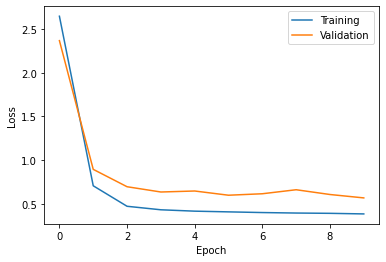

In [56]:
cf.plotting.plot_history(history_state)

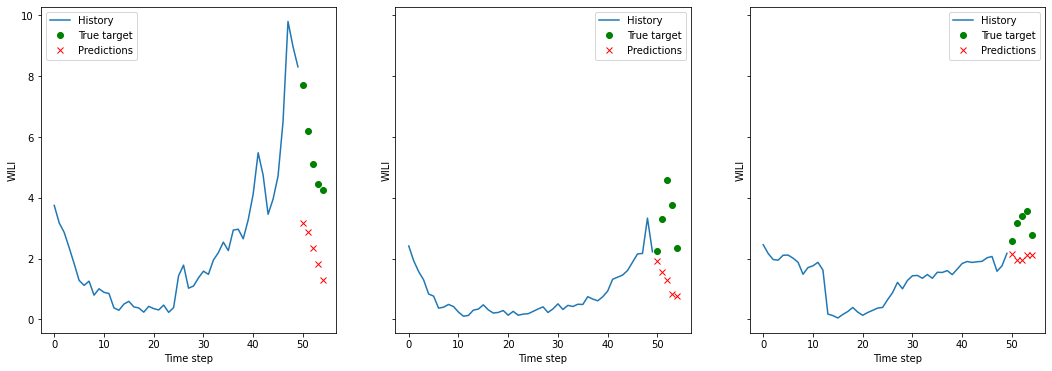

In [107]:
cf.plotting.plot_model_pred_sequential(lstm1, X_test, n=3, offset=20)

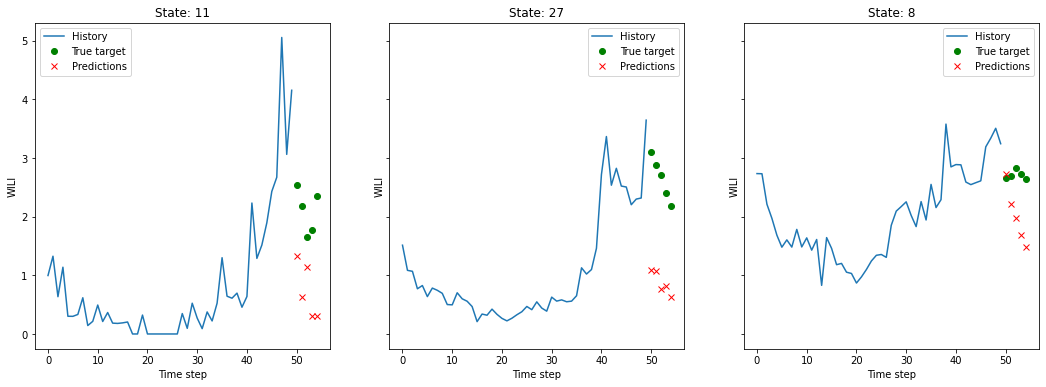

In [108]:
cf.plotting.plot_model_pred_sequential(lstm_state, X_test, n=3, offset=20,
                                       states=True)

In [80]:
lstm_state.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 368, 1)]     0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
masking_9 (Masking)             (None, 368, 1)       0           input_18[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 16)        848         input_19[0][0]                   
____________________________________________________________________________________________

In [93]:
state_embeds = lstm_state.get_layer('embedding_6').get_weights()
state_embeds = np.array(state_embeds)[0]
state_embeds.shape

(53, 16)

In [94]:
pca = PCA(n_components=2)
state_embeds_pca = pca.fit_transform(state_embeds)

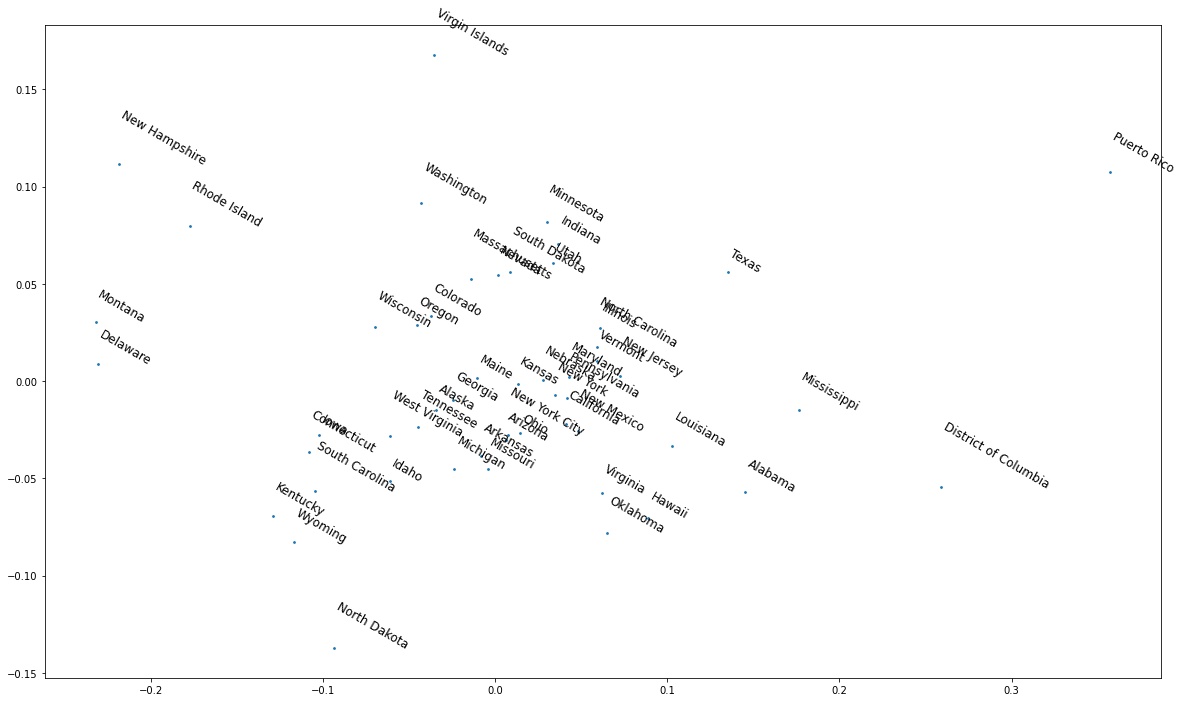

In [106]:
plt.figure(figsize=(20, 12))
plt.scatter(state_embeds_pca[:, 0], state_embeds_pca[:, 1], s=3)
for idx, state in id2state.items():
    plt.annotate(state, (state_embeds_pca[idx, 0], state_embeds_pca[idx, 1]), rotation=-30, size=12)